# 1. Feature Engineering

# 1.1 Load and Setup Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import IncrementalPCA
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, roc_curve)
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

2025-06-11 05:29:45.688774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749619786.155459      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749619786.296736      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load dataset
df_main = pd.read_csv('/kaggle/input/cleaned-dataset/cleaned_data.csv', low_memory=False, index_col=0)

# Make a copy to avoid modifying the original
df = df_main.copy()

# Separate target variable
y_all = df['isFraud'].values
df.drop(columns=['isFraud'], inplace=True)

## 1.2 Preprocess Columns

In [3]:
# Replace infrequent 'card2' values with 'others'
card2_counts = df['card2'].value_counts(dropna=False)
common_values = card2_counts[card2_counts > 1000].index
df['card2'] = df['card2'].apply(lambda x: x if x in common_values else 'others')

# Drop high-cardinality or non-useful columns
df.drop(columns=['card5', 'card1'], inplace=True)

## 1.3 Enconding and Scaling Features

In [4]:
# Define feature column groups
label_col = ['addr2']
cat_col = ['card2', 'P_emaildomain', 'ProductCD', 'card3', 'card4', 'addr1', 'DeviceType']
num_col = [
    'dist1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
    'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'VerificationSet', 'MatchingCount'
]

# Convert categorical columns to string before encoding
df[cat_col] = df[cat_col].astype(str)

In [5]:
# Initialize transformers
label_encoder = OrdinalEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

# Create column transformer
ct = ColumnTransformer(transformers=[
    ('label', label_encoder, label_col),
    ('onehot', onehot_encoder, cat_col),
    ('num', scaler, num_col)
])

In [6]:
# Keep already-encoded columns if needed (optional; you can remove if unnecessary)
keep_cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
keep = df[keep_cols]

## 1.4 Fit and Transform Data

In [7]:
# Apply transformations
X_transformed = ct.fit_transform(df)

# Get column names
X_transformed_df = pd.DataFrame(X_transformed, columns=ct.get_feature_names_out())

# Combine with optional kept features
X_all = pd.concat([X_transformed_df, keep], axis=1)

## 1.5 Incremental PCA

In [8]:
# Number of PCA components for each model
pca_dims = {
    'ocsvm': 15,
    'elliptic': 15,
    'lof': 10,
    'knn': 10,
}

# Store PCA-reduced features
X_models = {}

for model, n in pca_dims.items():
    ipca = IncrementalPCA(n_components=n, batch_size=512)
    X_models[model] = ipca.fit_transform(X_all)

# 2. Machine Learning Model for OCC

## 2.1 Training

In [9]:
def train_model_single(name, X, y, feature_names=None):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=feature_names) if feature_names else pd.DataFrame(X)

    X_normal = X[y == 0]
    scores = []

    if name == "ocsvm":
        model = OneClassSVM(
            kernel='rbf',
            nu=0.03,
            gamma=0.005
        )
        X_sub = X_normal.sample(n=min(40000, len(X_normal)), random_state=42)
        model.fit(X_sub)
        for i in range(0, len(X), 50000):
            batch_scores = model.decision_function(X.iloc[i:i+50000])
            scores.extend(batch_scores)
        scores = np.array(scores)
        # For OCSVM, scores < 0 are outliers. We negate them so higher score = more anomalous.
        scores = -scores
        pred = (model.predict(X) == -1).astype(int)
        return name, pred, scores

    elif name == "elliptic":
        model = EllipticEnvelope(
            contamination=0.01,
            support_fraction=0.8
        )
        model.fit(X_normal)
        for i in range(0, len(X), 50000):
            batch_scores = model.decision_function(X.iloc[i:i+50000])
            scores.extend(batch_scores)
        scores = np.array(scores)
        # For EllipticEnvelope, lower scores are more abnormal. We negate them.
        scores = -scores
        pred = (model.predict(X) == -1).astype(int)
        return name, pred, scores

    elif name == "isoforest":
        model = IsolationForest(
            n_estimators=250,
            max_samples='auto',
            contamination=0.01,
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_normal)
        for i in range(0, len(X), 50000):
            batch = X.iloc[i:i+50000]
            batch = pd.DataFrame(batch.values, columns=X.columns)
            # score_samples returns the opposite of the anomaly score. Higher is more normal.
            batch_scores = model.score_samples(batch)
            scores.extend(batch_scores)
        scores = np.array(scores)
        # We negate the scores so higher values are more anomalous
        scores = -scores
        pred = (model.predict(X) == -1).astype(int)
        return name, pred, scores

    elif name == "lof":
        model = LocalOutlierFactor(
            n_neighbors=20,
            contamination=0.01,
            novelty=True,
            metric='euclidean',
            n_jobs=-1
        )
        X_sub = X_normal.sample(n=min(50000, len(X_normal)), random_state=42)
        model.fit(X_sub)
        for i in range(0, len(X), 50000):
            # score_samples returns the opposite of the LOF. Higher is more normal.
            batch_scores = model.score_samples(X.iloc[i:i+50000])
            scores.extend(batch_scores)
        scores = np.array(scores)
        # We negate the scores so higher values are more anomalous
        scores = -scores
        pred = (model.predict(X) == -1).astype(int)
        return name, pred, scores

    elif name == "knn":
        knn = NearestNeighbors(
            n_neighbors=20,
            metric='euclidean',
            n_jobs=-1
        )
        # Fit on a large sample of normal data to identify points far from the normal distribution
        X_sub_normal = X_normal.sample(n=min(100000, len(X_normal)), random_state=42)
        knn.fit(X_sub_normal)
        for i in range(0, len(X), 50000):
            d, _ = knn.kneighbors(X.iloc[i:i+50000])
            scores.extend(d.mean(axis=1))
        scores = np.array(scores)
        # For k-NN distance, a higher score is more anomalous, so no need to negate.
        threshold = np.percentile(scores, 90)
        pred = (scores > threshold).astype(int)
        return name, pred, scores

    else:
        raise ValueError(f"Unknown model: {name}")

In [10]:
# Train One-Class SVM
name_ocsvm, y_pred_ocsvm, score_ocsvm = train_model_single("ocsvm", X_models['ocsvm'], y_all)

In [11]:
# Train Elliptic Envelope
name_elliptic, y_pred_elliptic, score_elliptic = train_model_single("elliptic", X_models['elliptic'], y_all)

In [12]:
# Train Isolation Forest
feature_names = X_all.columns.tolist()
name_isoforest, y_pred_isoforest, score_isoforest = train_model_single("isoforest", X_all, y_all)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [13]:
# Train Local Outlier Factor
name_lof, y_pred_lof, score_lof = train_model_single("lof", X_models['lof'], y_all)

In [14]:
# Train k-NN
name_knn, y_pred_knn, score_knn = train_model_single("knn", X_models['knn'], y_all)

## 2.2 Evaluation and Results

In [15]:
def evaluate_model_single(name, y_true, y_pred, score=None):
    if len(y_true) != len(y_pred):
        print(f"Warning: {name} - mismatched lengths, truncating y_true.")
        y_true = y_true[:len(y_pred)]

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, score if score is not None else y_pred),
        "Avg Precision": average_precision_score(y_true, score if score is not None else y_pred),
    }

    print(f"\n{name} Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return metrics

In [16]:
def compare_models(trained_models, y_true):
    results = {}
    for model_name, model_data in trained_models.items():
        y_pred = model_data["y_pred"]
        score = model_data["score"]
        metrics = evaluate_model_single(model_name, y_true, y_pred, score)
        results[model_name] = metrics

    comparison_df = pd.DataFrame(results).T  # Transpose for readability
    return comparison_df

In [17]:
# Store model results
results = {
    'ocsvm': (name_ocsvm, y_pred_ocsvm, score_ocsvm),
    'elliptic': (name_elliptic, y_pred_elliptic, score_elliptic),
    'isoforest': (name_isoforest, y_pred_isoforest, score_isoforest),
    'lof': (name_lof, y_pred_lof, score_lof),
    'knn': (name_knn, y_pred_knn, score_knn),
}

# Dictionary to store evaluation metrics
evaluation_results = {}

# Evaluate using a loop
for model_name, (name, y_pred, score) in results.items():
    print(f"Evaluating model: {model_name}")
    metrics = evaluate_model_single(name, y_all, y_pred, score)
    evaluation_results[model_name] = metrics

Evaluating model: ocsvm

ocsvm Metrics:
Accuracy: 0.9430
Precision: 0.1800
Recall: 0.1808
F1: 0.1804
ROC AUC: 0.6437
Avg Precision: 0.1124
Evaluating model: elliptic

elliptic Metrics:
Accuracy: 0.9575
Precision: 0.1641
Recall: 0.0546
F1: 0.0819
ROC AUC: 0.6753
Avg Precision: 0.0835
Evaluating model: isoforest

isoforest Metrics:
Accuracy: 0.9595
Precision: 0.2853
Recall: 0.1110
F1: 0.1598
ROC AUC: 0.7045
Avg Precision: 0.1152
Evaluating model: lof

lof Metrics:
Accuracy: 0.9570
Precision: 0.1025
Recall: 0.0307
F1: 0.0473
ROC AUC: 0.6431
Avg Precision: 0.0597
Evaluating model: knn

knn Metrics:
Accuracy: 0.8875
Precision: 0.1109
Recall: 0.3196
F1: 0.1646
ROC AUC: 0.6553
Avg Precision: 0.1218


In [18]:
# Create performance comparison table

# Convert the evaluation_results dictionary to a DataFrame
comparison_df = pd.DataFrame(evaluation_results).T  # Transpose so models are rows

# Sort by Precision
comparison_df = comparison_df.sort_values(by='Precision', ascending=False)

# Display
display(comparison_df)

,Accuracy,Precision,Recall,F1,ROC AUC,Avg Precision
isoforest,0.959504,0.285336,0.111018,0.159845,0.704483,0.115213
ocsvm,0.942988,0.179958,0.180779,0.180368,0.643679,0.112419
elliptic,0.957541,0.164062,0.054602,0.081935,0.675256,0.083476
knn,0.887478,0.110888,0.319564,0.164645,0.655329,0.121781
lof,0.957032,0.102472,0.030710,0.047258,0.643076,0.059736



Model Visualizations and Confusion Matrices

--- Results for ocsvm ---
Confusion Matrix:
[[550265  16792]
 [ 16699   3685]]


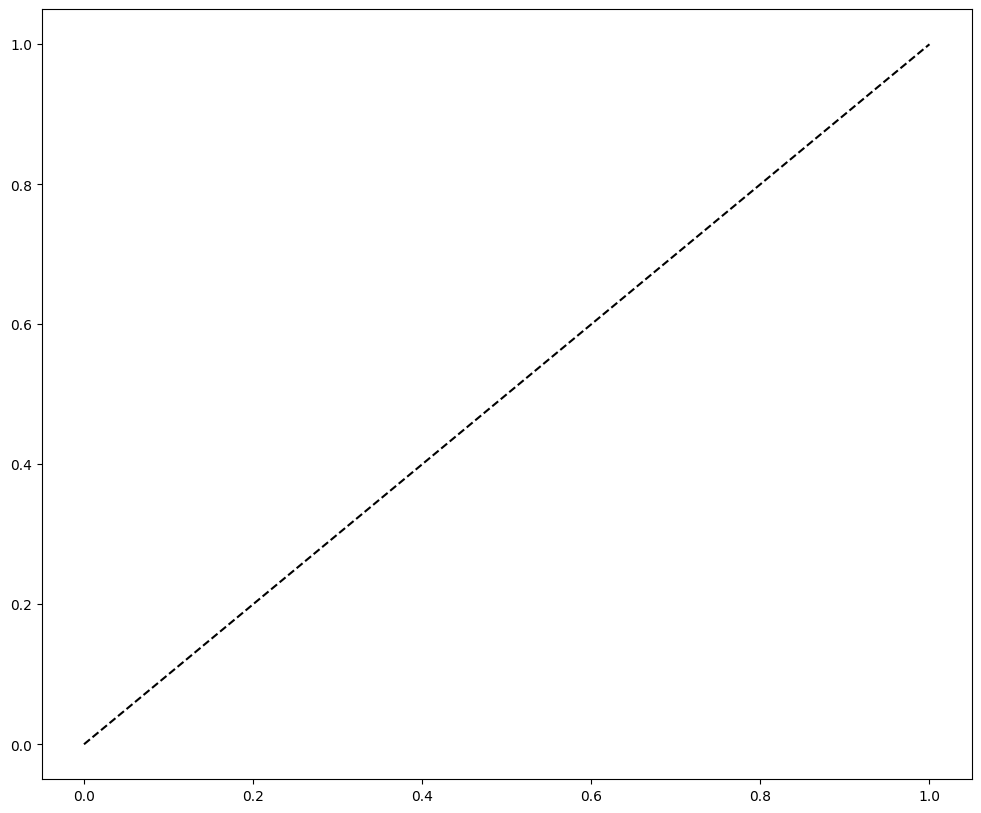

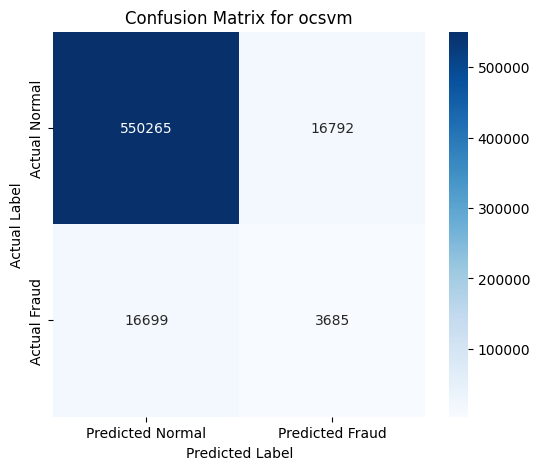

--- Results for elliptic ---
Confusion Matrix:
[[561386   5671]
 [ 19271   1113]]


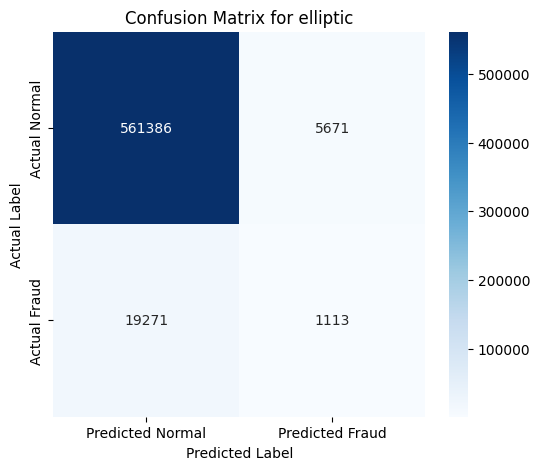

--- Results for isoforest ---
Confusion Matrix:
[[561389   5668]
 [ 18121   2263]]


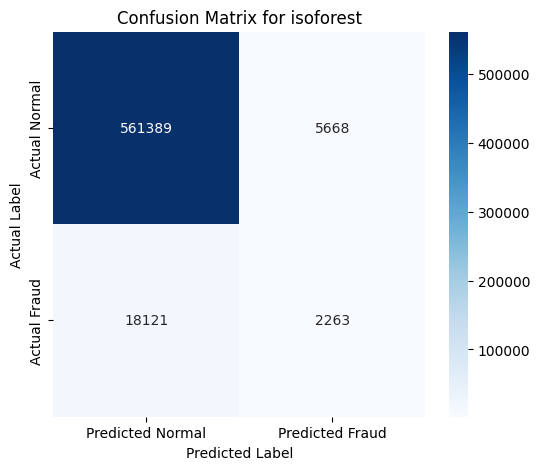

--- Results for lof ---
Confusion Matrix:
[[561574   5483]
 [ 19758    626]]


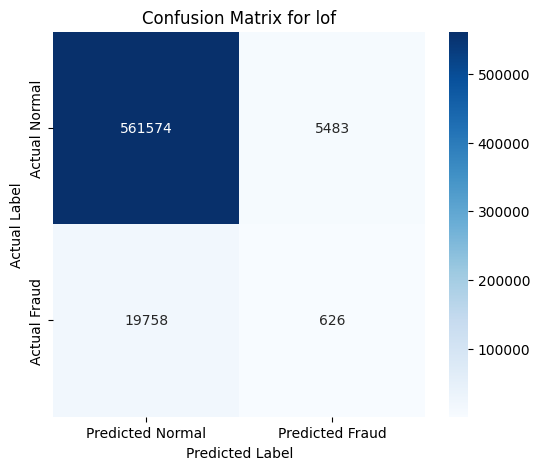

--- Results for knn ---
Confusion Matrix:
[[514827  52230]
 [ 13870   6514]]


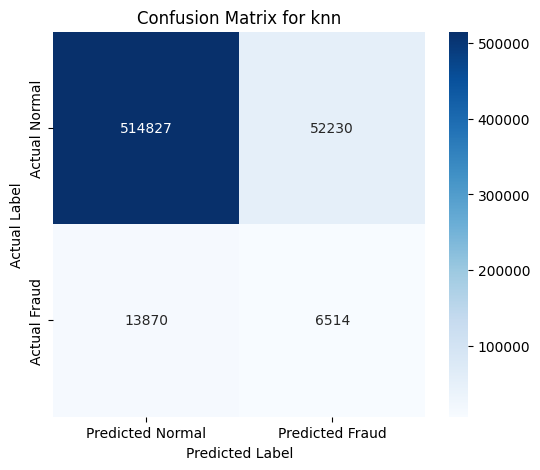

In [19]:
# 3. Visualization and Confusion Matrices

# Create a figure for the combined ROC curve plot
fig_roc, ax_roc = plt.subplots(figsize=(12, 10))
ax_roc.plot([0, 1], [0, 1], 'k--', label='No Skill (AUC = 0.5)') # Dashed diagonal

print("\n" + "="*50)
print("Model Visualizations and Confusion Matrices")
print("="*50 + "\n")

# Loop through the results to plot ROC curves and confusion matrices
for model_name, (name, y_pred, score) in results.items():
    print(f"--- Results for {name} ---")
    
    # --- Confusion Matrix ---
    cm = confusion_matrix(y_all, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Visualize the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Normal', 'Predicted Fraud'], 
                yticklabels=['Actual Normal', 'Actual Fraud'])
    plt.title(f'Confusion Matrix for {name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # --- ROC Curve ---
    if score is not None:
        # The score should represent the likelihood of being an anomaly (fraud).
        # Higher score = more likely to be fraud.
        fpr, tpr, _ = roc_curve(y_all, score)
        auc_score = roc_auc_score(y_all, score)
        
        # Plotting on the combined ROC curve figure
        ax_roc.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')
    else:
        print(f"\nSkipping ROC curve for {model_name} as scores are not available.")

# Finalizing the combined ROC curve plot
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curves for All Models')
ax_roc.legend()
ax_roc.grid(True)
plt.show()